In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import os
import random
from io import BytesIO
from uuid import uuid4

import numpy as np
import diffusers
import einops
import PIL
import requests
import sh
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
from attention_augmentation import collect_attention, replace_attention
from controlnet_aux import HEDdetector
from diffusers import (
    ControlNetModel,
    DDIMInverseScheduler,
    DDIMScheduler,
    EulerAncestralDiscreteScheduler,
    StableDiffusionControlNetPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionPipeline,
    UniPCMultistepScheduler,
)
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint import *
from diffusers.utils.torch_utils import randn_tensor
from einops import rearrange, repeat
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import sh
from utils import generate_circular_gradient, display_images
from PIL import ImageFilter

/home/robert/miniconda3/envs/ergot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/robert/miniconda3/envs/ergot/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
def zz(obj, depth=0):
    if type(obj) == list:
        # do we need to expand the internal items?
        if type(obj[0]) in [list, torch.Tensor, np.array, dict]:
            nl = "\n" + "  " * (1 + depth)
            inner = nl + nl.join([zz(item, depth + 1) for item in obj])
            return f"list ({len(obj)}) of [{inner}]"
        else:
            return len(obj)
    if type(obj) == torch.Tensor or type(obj) == np.array:
        return str(obj.shape)
    if type(obj) in [int, float, str, bool]:
        return str(obj)
    if type(obj) == dict:
        nl = "\n" + "  " * (1 + depth)
        inner = nl + nl.join(f"{k}: {zz(v, depth + 1)}" for k, v in obj.items())
        return f"dict of {{{inner}}}"
    else:
        return "?"

In [4]:
dt = torch.bfloat16

In [5]:
base_model = "Lykon/DreamShaper"
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=dt).cuda()
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", safety_checker=None, controlnet=controlnet, variant="bf16", torch_dtype=dt).to("cuda")
pipe.safety_checker = None

[p.requires_grad_(False) for p in [pipe.vae, pipe.unet, pipe.text_encoder, controlnet]]

/home/robert/miniconda3/envs/ergot/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:1223: FutureWarning: You are trying to load the model files of the `variant=bf16`, but no such modeling files are available.The default model files: {'text_encoder/model.safetensors', 'safety_checker/pytorch_model.bin', 'vae/diffusion_pytorch_model.bin', 'unet/diffusion_pytorch_model.bin', 'vae/diffusion_pytorch_model.safetensors', 'unet/diffusion_pytorch_model.safetensors', 'safety_checker/model.safetensors', 'text_encoder/pytorch_model.bin'} will be loaded instead. Make sure to not load from `variant=bf16`if such variant modeling files are not available. Doing so will lead to an error in v0.22.0 as defaulting to non-variantmodeling files is deprecated.
  deprecate("no variant default", "0.22.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `s

[AutoencoderKL(
   (encoder): Encoder(
     (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (down_blocks): ModuleList(
       (0): DownEncoderBlock2D(
         (resnets): ModuleList(
           (0-1): 2 x ResnetBlock2D(
             (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
             (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
             (dropout): Dropout(p=0.0, inplace=False)
             (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (nonlinearity): SiLU()
           )
         )
         (downsamplers): ModuleList(
           (0): Downsample2D(
             (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
           )
         )
       )
       (1): DownEncoderBlock2D(
         (resnets): ModuleList(
           (0): ResnetBlock2D(
             (norm1): GroupNorm(32, 128, eps=1e-06, af

In [6]:
ts = 300
ddim_inv = DDIMInverseScheduler.from_config(pipe.scheduler.config)
ddim_fwd = DDIMScheduler.from_config(pipe.scheduler.config)
ddim_inv.set_timesteps(ts)
ddim_fwd.set_timesteps(ts)
# pipe.scheduler = EulerAncestralDiscreteScheduler().from_config(pipe.scheduler.config) #ddim_fwd
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(ts)

In [7]:
frame_shape = (512, 512)
sh.mkdir("-p", "frames")
sh.ffmpeg("-i", "original.mp4", "-vf", f"crop=512:512:(in_w-512)/2:(in_h-512)/2", "-r", "15", f"frames/%04d.png")
frames = [Image.open(x).resize(frame_shape, Image.LANCZOS) for x in sorted([f"frames/{x}" for x in os.listdir("frames")])]
# frames = [f.filter(ImageFilter.GaussianBlur(radius = 25)) for f in frames[0:10]]
frames = frames[0:10]
prompt = "Man shaving wood flakes"

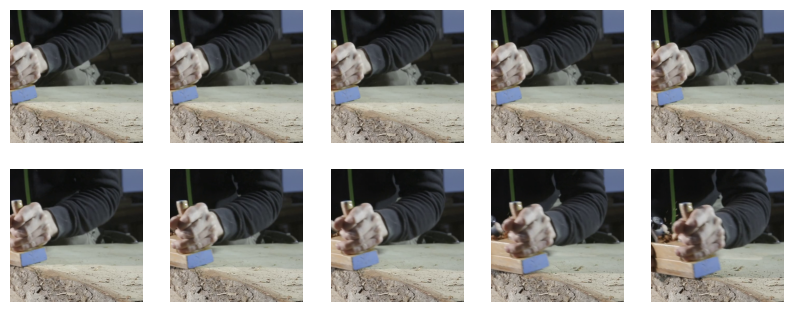

In [8]:
display_images(frames)

In [9]:
def latents_to_img(latents):
    decoded = pipe.vae.decode(latents.unsqueeze(0) / pipe.vae.config.scaling_factor)[0].squeeze()
    return TF.to_pil_image((decoded / 2 + 0.5).clamp(0, 1))

In [10]:
def frame_to_tensor(image):
    return TF.pil_to_tensor(image).to(dt).cuda() / 256

In [11]:
preprocess = HEDdetector.from_pretrained("lllyasviel/Annotators")
preprocessed_frames = [TF.pil_to_tensor(preprocess(f).resize(frame_shape)).to(dt) / 256 for f in tqdm(frames)]

100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


In [12]:
from attention_modules import CorrespondingAttention, ExtendedAttention, NormalAttention, SaveAttention

In [53]:
??pipe

Signature:     
pipe(
    prompt: Union[str, List[str]] = None,
    image: Union[torch.FloatTensor, PIL.Image.Image, numpy.ndarray, List[torch.FloatTensor], List[PIL.Image.Image], List[numpy.ndarray]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    negative_prompt: Union[str, List[str], NoneType] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Union[torch._C.Generator, List[torch._C.Generator], NoneType] = None,
    latents: Optional[torch.FloatTensor] = None,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    output_type: Optional[str] = 'pil',
    return_dict: bool = True,
    callback: Optional[Callable[[int, int, torch.FloatTensor], NoneType]] = None,
    callback_steps: int = 1,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    controlnet_conditioning_scal

100%|██████████| 300/300 [00:06<00:00, 45.05it/s]


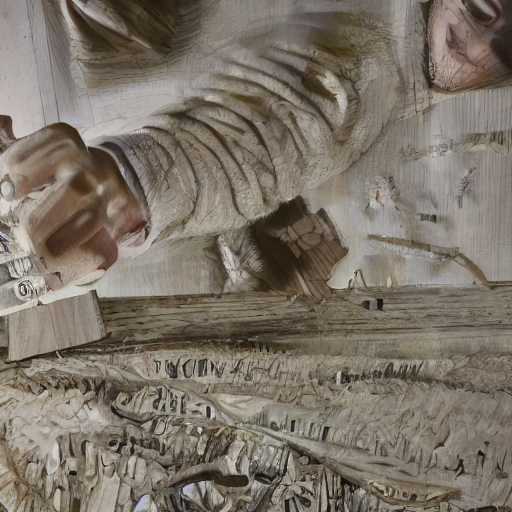

In [54]:
pipe(prompt="man hand, sanding down wood work", image=TF.to_pil_image(preprocessed_frames[0]), num_inference_steps=300, guidance_scale=1.0).images[0]

In [14]:
replace_attention(pipe.unet, ExtendedAttention)

In [15]:
def invert_ddim(target_timestep, frame_indices):
    tensor_frames = torch.stack([frame_to_tensor(frames[i]) * 2 - 1 for i in frame_indices]).cuda()  # should do *2 -1 probably? TODO
    prompt_embeds = pipe._encode_prompt(prompt, "cuda", do_classifier_free_guidance=False, num_images_per_prompt=len(frame_indices))

    latents = pipe.vae.encode(tensor_frames.to(dt).cuda()).latent_dist.sample() * pipe.vae.config.scaling_factor
    # guidance = torch.stack([preprocessed_frames[i] for i in frame_indices]).cuda()

    for t in tqdm(([t for t in ddim_inv.timesteps if t < target_timestep])):
        noise_pred = pipe.unet(latents, t, prompt_embeds).sample
        latents = ddim_inv.step(noise_pred, t, latents).prev_sample

    replace_attention(pipe.unet, SaveAttention)
    noise_pred = pipe.unet(latents, target_timestep, prompt_embeds).sample

    return latents

In [16]:
ddim_inv.timesteps

tensor([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,  40,
         43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,  79,  82,
         85,  88,  91,  94,  97, 100, 103, 106, 109, 112, 115, 118, 121, 124,
        127, 130, 133, 136, 139, 142, 145, 148, 151, 154, 157, 160, 163, 166,
        169, 172, 175, 178, 181, 184, 187, 190, 193, 196, 199, 202, 205, 208,
        211, 214, 217, 220, 223, 226, 229, 232, 235, 238, 241, 244, 247, 250,
        253, 256, 259, 262, 265, 268, 271, 274, 277, 280, 283, 286, 289, 292,
        295, 298, 301, 304, 307, 310, 313, 316, 319, 322, 325, 328, 331, 334,
        337, 340, 343, 346, 349, 352, 355, 358, 361, 364, 367, 370, 373, 376,
        379, 382, 385, 388, 391, 394, 397, 400, 403, 406, 409, 412, 415, 418,
        421, 424, 427, 430, 433, 436, 439, 442, 445, 448, 451, 454, 457, 460,
        463, 466, 469, 472, 475, 478, 481, 484, 487, 490, 493, 496, 499, 502,
        505, 508, 511, 514, 517, 520, 523, 526, 529, 532, 535, 5

In [17]:
ddim_fwd.timesteps

tensor([898, 895, 892, 889, 886, 883, 880, 877, 874, 871, 868, 865, 862, 859,
        856, 853, 850, 847, 844, 841, 838, 835, 832, 829, 826, 823, 820, 817,
        814, 811, 808, 805, 802, 799, 796, 793, 790, 787, 784, 781, 778, 775,
        772, 769, 766, 763, 760, 757, 754, 751, 748, 745, 742, 739, 736, 733,
        730, 727, 724, 721, 718, 715, 712, 709, 706, 703, 700, 697, 694, 691,
        688, 685, 682, 679, 676, 673, 670, 667, 664, 661, 658, 655, 652, 649,
        646, 643, 640, 637, 634, 631, 628, 625, 622, 619, 616, 613, 610, 607,
        604, 601, 598, 595, 592, 589, 586, 583, 580, 577, 574, 571, 568, 565,
        562, 559, 556, 553, 550, 547, 544, 541, 538, 535, 532, 529, 526, 523,
        520, 517, 514, 511, 508, 505, 502, 499, 496, 493, 490, 487, 484, 481,
        478, 475, 472, 469, 466, 463, 460, 457, 454, 451, 448, 445, 442, 439,
        436, 433, 430, 427, 424, 421, 418, 415, 412, 409, 406, 403, 400, 397,
        394, 391, 388, 385, 382, 379, 376, 373, 370, 367, 364, 3

In [18]:
import matplotlib.pyplot as plt

In [19]:
# t = 0 is real image
# t = 1000 is isotropic noise
# beta = variance we add at each step. Betas increase, since at higher steps (more noise) we add more noise.
# alpha = 1 - beta, ignore this.
# alphas_cumprod = how much signal is left in the image at timestep t. Should be 1 at t=0, and 0 at t=1000.

In [20]:
def uninvert_ddim(target_timestep, inverted_latents):
    # tensor_frames = torch.stack([frame_to_tensor(frames[i]) * 2 - 1 for i in frame_indices]).cuda()  # should do *2 -1 probably? TODO
    prompt_embeds = pipe._encode_prompt(prompt, "cuda", do_classifier_free_guidance=False, num_images_per_prompt=1).detach()

    # latents = pipe.vae.encode(tensor_frames.to(dt).cuda()).latent_dist.sample() * pipe.vae.config.scaling_factor
    latents = inverted_latents.detach()
    # guidance = torch.stack([preprocessed_frames[i] for i in frame_indices]).cuda()

    for t in tqdm(([t for t in ddim_fwd.timesteps if t < target_timestep])):
        noise_pred = pipe.unet(latents, t, prompt_embeds).sample.detach()
        latents = ddim_fwd.step(noise_pred, t, latents).prev_sample.detach()

    # replace_attention(pipe.unet, SaveAttention)
    # noise_pred = pipe.unet(latents, t, prompt_embeds).sample

    return latents

In [21]:
noise_latents = invert_ddim(1000, [5])

  1%|          | 3/300 [00:00<00:10, 29.38it/s]

100%|██████████| 300/300 [00:04<00:00, 63.62it/s]


In [22]:
noise_latents[0].mean()

tensor(0.0194, device='cuda:0', dtype=torch.bfloat16)

In [23]:
# uninverted = uninvert_ddim(1000, noise_latents)

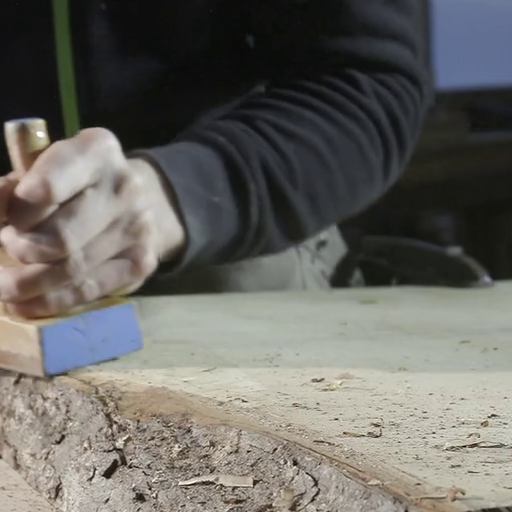

In [24]:
frames[5]

In [25]:
# latents_to_img(uninverted[0])

In [26]:
def get_attention_activations_at_t(timestep, frame_indices):
    latents = invert_ddim(timestep, frame_indices)
    out = collect_attention(pipe.unet, lambda x: x.history[0])
    return out

In [27]:
total_attn_layers = 32


def batched_get_attention_activations_at_t(timestep, frame_indices):
    bs = 10
    batched_indices = [frame_indices[i : i + bs] for i in range(0, len(frame_indices), bs)]
    batched_res = [get_attention_activations_at_t(timestep, bi) for bi in batched_indices]
    return [torch.cat([b[l] for b in batched_res]).cpu() for l in range(total_attn_layers)]

0it [00:00, ?it/s]

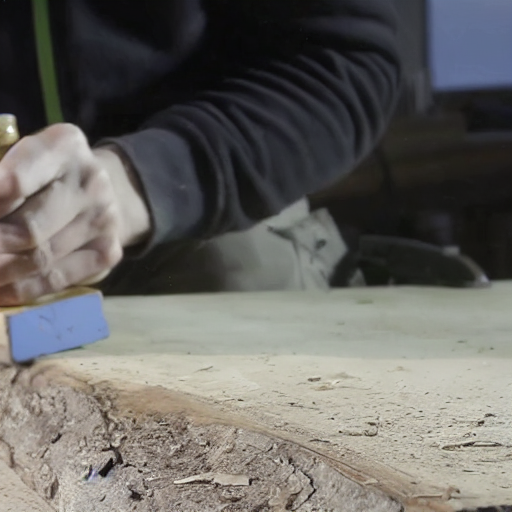

In [28]:
latents_to_img(invert_ddim(1, [1, 3, 5])[0])

In [29]:
# bat = batched_get_attention_activations_at_t(1, [1, 3, 5, 7, 9])
# bat = get_attention_activations_at_t(500, [1, 3, 5, 7, 9])
bat = batched_get_attention_activations_at_t(100, [0, 2, 9])

  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:01<00:00, 32.14it/s]


In [30]:
print(zz(bat))  # attention layer x ? x frames x hw x c

list (32) of [
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 256, 1280])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 1024, 640])
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 4096, 320])
  torch.Size([3, 64, 1280])
  torch.Size([3, 64, 1280])]


In [31]:
len(bat)

32

In [32]:
def compute_principal_components(batch):
    batch_reshaped = einops.rearrange(batch, "b hw c -> (b hw) c")
    batch_normalized = (batch_reshaped - batch_reshaped.mean(dim=0)) / batch_reshaped.std(dim=0)
    cov_matrix = torch.mm(batch_normalized.T, batch_normalized) / (batch_normalized.size(0) - 1)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    idx = torch.argsort(eigenvalues, descending=True)
    principal_components = eigenvectors[:, idx[:3]]
    batch_projected = torch.mm(batch_normalized, principal_components)
    batch_projected = einops.rearrange(batch_projected, "(b hw) c -> b hw c", b=batch.size(0), hw=batch.size(1))
    return batch_projected

In [33]:
# collect_attention(pipe.unet, lambda x: len(x.history))

torch.Size([3, 256, 3])


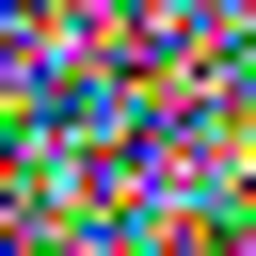

In [34]:
layer = 15
dim = int(bat[layer][0].shape[0] ** 0.5)
inp = bat[layer].float()
# vecs = torch.randn(5, 3)
# inp = vecs[torch.randint(0, 5, (5, dim * dim))]
factored = compute_principal_components(inp)
print(factored.shape)

TF.to_pil_image(factored[0].reshape(dim, dim, 3).permute(2, 0, 1)).resize((256, 256))
# TF.to_pil_image(torch.mean(torch.abs(bat[layer][0] - bat[layer][4]), dim = -1).reshape(dim, dim) * 25).resize((256, 256))
# b1 = vecwise_norm(bat[layer][0])
# b2 = vecwise_norm(bat[layer][4])
# sim = torch.einsum('jk,jk->j', [b1, b2]).reshape(dim, dim) * 250
# print(sim)
# TF.to_pil_image(sim.to(torch.uint8)).resize((256, 256))

In [35]:
def vecwise_norm(x):
    return x / torch.linalg.norm(x, dim=-1, keepdim=True)

In [36]:
def get_attn_transitions(target_timestep, key_indices):
    out = []
    all_frames = range(len(frames))

    print(target_timestep, all_frames)
    maps = batched_get_attention_activations_at_t(target_timestep, all_frames)  # [layer][frame][hw][c]

    for layer in range(len(maps)):
        this_attn_layer = []
        for current_i in all_frames:
            before_i = max([0] + [i for i in key_indices if i < current_i])
            after_i = min([i for i in key_indices if i > current_i] + [max(all_frames)])

            # need to use double here, otherwise we lose too much precision and our nearest neighbors are very wrong
            before = vecwise_norm(maps[layer][before_i].cuda().double())
            after = vecwise_norm(maps[layer][after_i].cuda().double())
            current = vecwise_norm(maps[layer][current_i].cuda().double())

            before_attn_transitions = before.cuda() @ einops.rearrange(current, "hw c -> c hw")
            before_argmax = torch.argmax(before_attn_transitions, dim=0).cpu()
            after_attn_transitions = after.cuda() @ einops.rearrange(current, "hw c -> c hw")
            after_argmax = torch.argmax(after_attn_transitions, dim=0).cpu()

            this_attn_layer.append({"center_frame": current_i, "before_frame": before_i, "after_frame": after_i, "before": before_argmax, "after": after_argmax})
        out.append(this_attn_layer)
    return out

In [37]:
all_attn_transitions = get_attn_transitions(100, [0, 2, 9])

100 range(0, 10)


100%|██████████| 33/33 [00:02<00:00, 11.31it/s]


In [38]:
len(all_attn_transitions[0])

10

In [39]:
print(zz(all_attn_transitions))

list (32) of [
  list (10) of [
    dict of {
      center_frame: 0
      before_frame: 0
      after_frame: 2
      before: torch.Size([4096])
      after: torch.Size([4096])}
    dict of {
      center_frame: 1
      before_frame: 0
      after_frame: 2
      before: torch.Size([4096])
      after: torch.Size([4096])}
    dict of {
      center_frame: 2
      before_frame: 0
      after_frame: 9
      before: torch.Size([4096])
      after: torch.Size([4096])}
    dict of {
      center_frame: 3
      before_frame: 2
      after_frame: 9
      before: torch.Size([4096])
      after: torch.Size([4096])}
    dict of {
      center_frame: 4
      before_frame: 2
      after_frame: 9
      before: torch.Size([4096])
      after: torch.Size([4096])}
    dict of {
      center_frame: 5
      before_frame: 2
      after_frame: 9
      before: torch.Size([4096])
      after: torch.Size([4096])}
    dict of {
      center_frame: 6
      before_frame: 2
      after_frame: 9
      before: torch

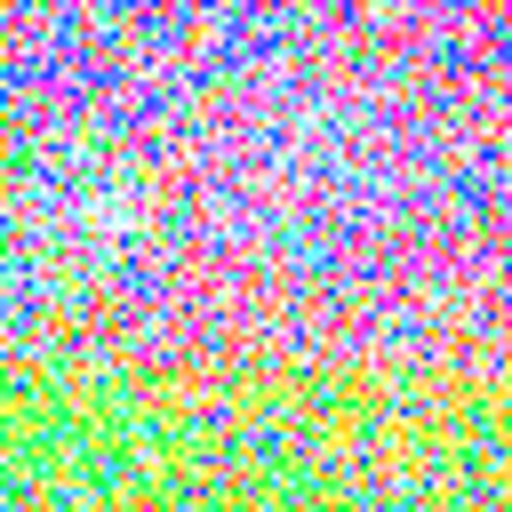

In [40]:
view_layer = 29
view_frame = 3
transitions = all_attn_transitions[view_layer][view_frame]["after"]
# transitions = np.arange(4096)
items = len(transitions)
base_size = round(items**0.5)
colored_image = TF.pil_to_tensor(generate_circular_gradient(base_size))
TF.to_pil_image((colored_image.reshape(3, base_size * base_size)[:, transitions]).reshape(3, base_size, base_size)).resize((512, 512))

In [41]:
[(c["before_frame"], c["center_frame"], c["after_frame"]) for c in all_attn_transitions[2]]

[(0, 0, 2),
 (0, 1, 2),
 (0, 2, 9),
 (2, 3, 9),
 (2, 4, 9),
 (2, 5, 9),
 (2, 6, 9),
 (2, 7, 9),
 (2, 8, 9),
 (2, 9, 9)]

In [43]:
batch_size = 4

In [44]:
fs_ddim = DDIMScheduler.from_config(pipe.scheduler.config)


def flow_stage(all_latents, attn_transitions, t, keyframe_attns, tb_true_to_batch_index, blacklist_indexes):
    flow_target_batch_size = 10
    for batch_indexes in torch.split(torch.arange(len(frames)), flow_target_batch_size):
        batch_indexes = torch.stack([x for x in batch_indexes if x not in blacklist_indexes])
        prompt_embeds = pipe._encode_prompt(
            prompt,
            "cuda",
            do_classifier_free_guidance=False,
            num_images_per_prompt=len(batch_indexes),
        )

        controlnet_guidance = torch.stack([preprocessed_frames[i] for i in batch_indexes]).cuda()

        batch_attn_transitions = [[l[bi] for bi in batch_indexes] for l in attn_transitions]

        replace_attention(
            pipe.unet,
            CorrespondingAttention,
            attn_transitions=batch_attn_transitions,
            active_frames=batch_indexes,
            keyframe_attns=keyframe_attns,
            tb_true_to_batch_index=tb_true_to_batch_index,
        )

        latents = all_latents[batch_indexes]
        latent_model_inputs = latents
        latent_model_inputs = fs_ddim.scale_model_input(latent_model_inputs, t)  # why this? not a no-op for Euler Ancestral

        down_block_res_samples, mid_block_res_samples = controlnet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=controlnet_guidance,
            conditioning_scale=1.0,
            return_dict=False,
            guess_mode=True,
        )
        noise_pred = pipe.unet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=down_block_res_samples,
            mid_block_additional_residual=[mid_block_res_samples][0],
            return_dict=False,
        )[0]

        cfg_noise = noise_pred

        latents = fs_ddim.step(cfg_noise, t, latents, return_dict=False)[0]
        all_latents[batch_indexes] = latents

In [50]:
fs_ddim = DDIMScheduler.from_config(pipe.scheduler.config)
fs_ddim.set_timesteps(ts)
es_ddim = DDIMScheduler.from_config(pipe.scheduler.config)
es_ddim.set_timesteps(ts)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(ts)
timesteps = pipe.scheduler.timesteps

original_noise = (
    torch.randn(
        len(frames),
        pipe.vae.config.latent_channels,
        frame_shape[1] // pipe.vae_scale_factor,
        frame_shape[0] // pipe.vae_scale_factor,
    )
    .to(dt)
    .cuda()
)
all_latents = original_noise * pipe.scheduler.init_noise_sigma

prompt_embeds = pipe._encode_prompt(
    prompt,
    "cuda",
    do_classifier_free_guidance=False,
    num_images_per_prompt=batch_size,
)

with torch.no_grad():
    [p.eval for p in [pipe.vae, pipe.unet, pipe.text_encoder, controlnet]]
    for i, t in tqdm(enumerate(timesteps)):
        replace_attention(pipe.unet, NormalAttention)
        # replace_attention(pipe.unet, ExtendedAttention)
        # random_frame_indexes = sorted([0] + [len(frames) - 1] + random.sample(range(1, len(frames) - 1), batch_size - 2))
        random_frame_indexes = [0, 3, 6, 9]

        random_controlnet_guidance = torch.stack([preprocessed_frames[i] for i in random_frame_indexes]).cuda()
        random_latents = all_latents[random_frame_indexes]
        latent_model_inputs = random_latents

        latent_model_inputs = pipe.scheduler.scale_model_input(latent_model_inputs, t)

        # only do inference on the positive side of CFG, since we have guess mode = True
        down_block_res_samples, mid_block_res_samples = controlnet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=random_controlnet_guidance,
            conditioning_scale=1.0,
            return_dict=False,
        )

        noise_pred = pipe.unet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=down_block_res_samples,  # double_blocks(down_block_res_samples),
            mid_block_additional_residual=mid_block_res_samples,  # double_blocks([mid_block_res_samples])[0],
            return_dict=False,
        )[0]

        cfg_noise = noise_pred

        all_latents[random_frame_indexes] = es_ddim.step(cfg_noise, t, random_latents, return_dict=False)[0]

        keyframe_attns = collect_attention(pipe.unet, lambda x: x.history)

        tb_true_to_batch_index = {ri: i for i, ri in enumerate(random_frame_indexes)}

        # attn_transitions = get_attn_transitions(t, random_frame_indexes)
        # flow_stage(all_latents, attn_transitions, t, keyframe_attns, tb_true_to_batch_index, [])

300it [00:17, 17.29it/s]


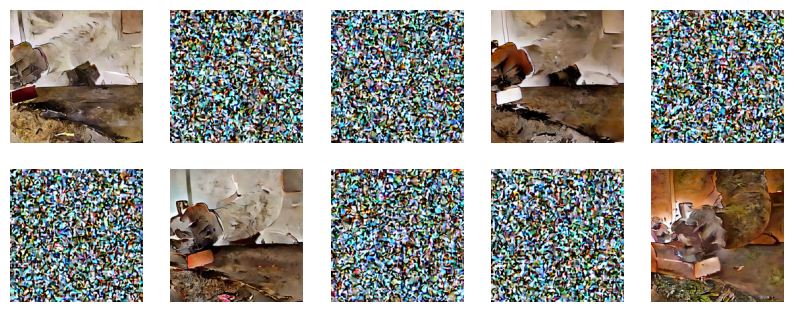

In [51]:
display_images([latents_to_img(i).resize((200, 200), Image.LANCZOS) for i in all_latents])

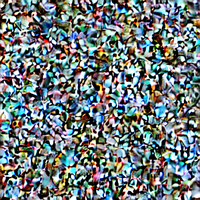

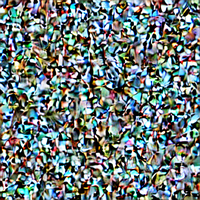

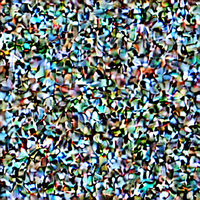

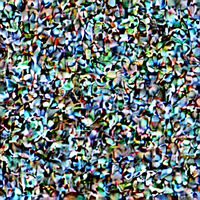

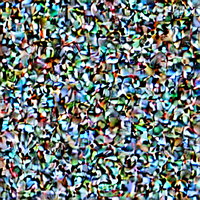

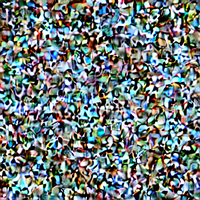

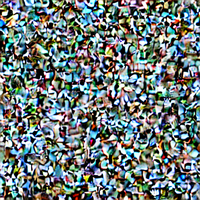

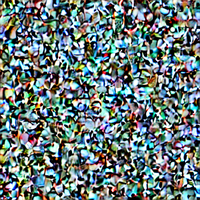

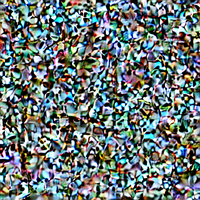

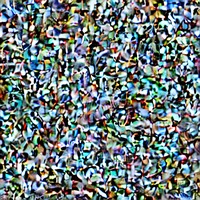

In [47]:
display(*[latents_to_img(i).resize((200, 200), Image.LANCZOS) for i in all_latents])